In [ ]:
#reading raw ECG data into a dataframe
import pandas as pd
ecg_df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Driver_Drowsiness/sleep_dataset_1.csv')
ecg_df_1.info

In [2]:
#converting lab tech profusion readings (hypnograph readings) into a dataframe:
import xml.etree.ElementTree as ET
import pandas as pd

xml_data = open('/content/drive/MyDrive/Colab Notebooks/Driver_Drowsiness/sleep_dataset_1_profusions.xml', 'r').read()  # Read file
root = ET.XML(xml_data)  # Parse XML

data = []
cols = []
for i, child in enumerate(root):
    data.append([subchild.text for subchild in child])
    cols.append(child.tag)

hypno_df = pd.DataFrame(data).T  # Write in DF and transpose it
hypno_df.columns = cols  # Update column names

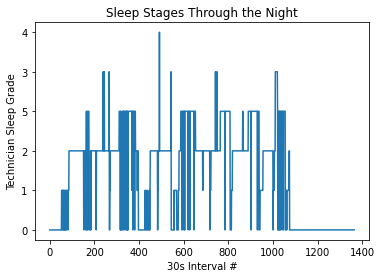

In [3]:
#plotting sleep stages through night
import numpy as np
import matplotlib.pyplot as plt

sleep_stages = hypno_df.SleepStages
plt.plot(np.arange(1,len(sleep_stages)+1),sleep_stages)
plt.title('Sleep Stages Through the Night')
plt.xlabel('30s Interval #')
plt.ylabel('Technician Sleep Grade')
plt.show()

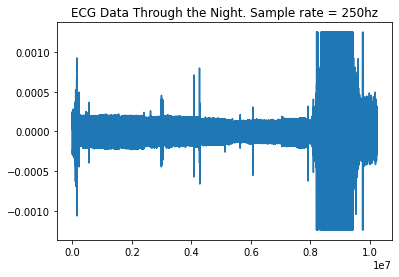

In [4]:
#plotting ECG data through night
ecg_time_series = ecg_df_1['# ECG']
plt.plot(np.arange(1,len(ecg_time_series)+1),ecg_time_series)
plt.title('ECG Data Through the Night. Sample rate = 250hz')
plt.show()

# Data Notes


1.   ECG/Sleep data was recorded over 11 hours and 22 mins (11.3667 hours)
2.   Sleep Grade Marked every 30 seconds (window = 30s)
3.   ECG sampled 250 times/second (250hz)



In [28]:
#converting ecg/sleep grade time series --> np arrays
sleep_stages = np.array(sleep_stages)
ecg_data = np.array(ecg_time_series)
print(f'Sleep Stage Vector Shape: {sleep_stages.shape}')
print(f'ECG Vector Shape: {ecg_data.shape}')
#parsing ecg data by 30s intervals
ecg_interval_data = np.array(np.split(ecg_data,len(sleep_stages)))
print(ecg_interval_data.shape)

Sleep Stage Vector Shape: (1364,)
ECG Vector Shape: (10230000,)
(1364, 7500)


Note: I eliminated peal intervals where the detected peak count was outside of range 30-->40. This cut our entire dataset size by ~290 samples (1076 remain). If model cannot train accurately on this smaller sample size. We will have to go back and learn how to pre_process eratic ECG signals

In [289]:
#helper function to plot interval sleep stage/ecg data
def plot_interval_data(interval_ecg,interval_hypnogram):
  #plotting sleep stage vs. ecg reading overall
  fig, axs = plt.subplots(2,figsize=(10,20))
  fig.suptitle('30s Interval Hypnogram & ECG')
  axs[0].plot(np.arange(len(interval_ecg)), [interval_hypnogram]*len(interval_ecg))
  axs[0].set_title('Hypnogram Reading')
  axs[1].plot(np.arange(len(interval_ecg)), interval_ecg)
  axs[1].set_title('ECG Reading')
  fig.show()

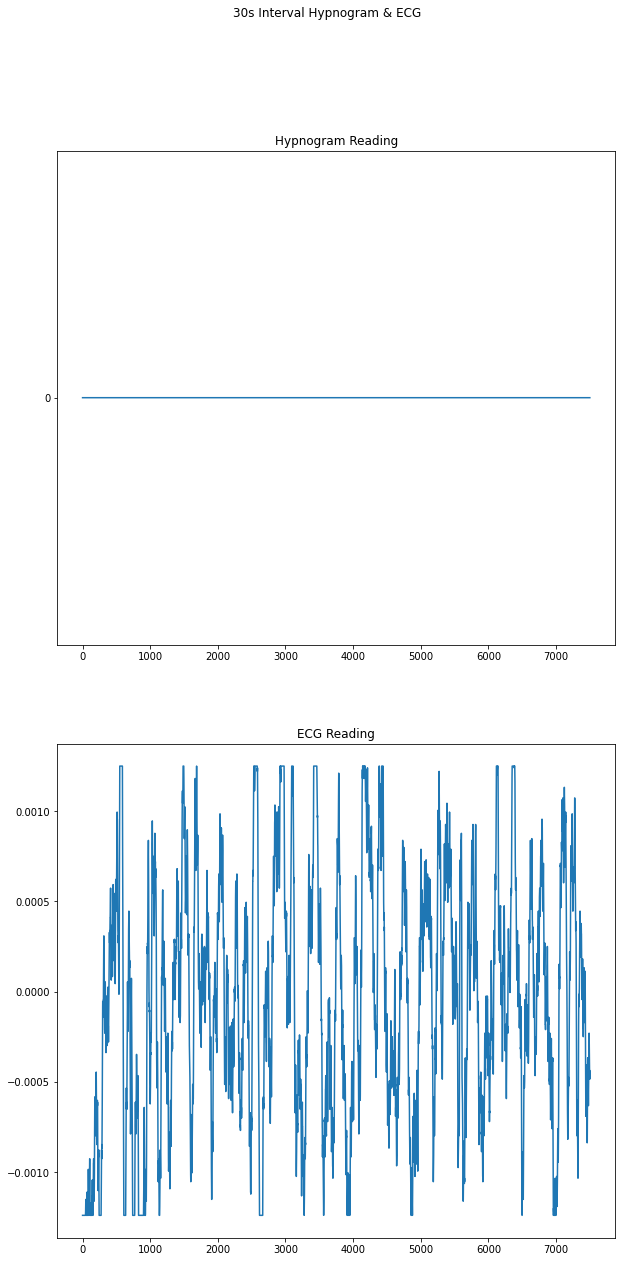

In [290]:
#this cell plots the ecg/sleep stage data for a "bad" intervals with eratic ECG data
bad_interval_index = 1225
bad_interval_ecg = ecg_interval_data[bad_interval_index,:]
bad_interval_hypno = sleep_stages[bad_interval_index]
plot_interval_data(bad_interval_ecg,bad_interval_hypno)

In [76]:
%%time
#calculating RR peak interval from ECG data:
import biosppy as bsp

#calculating peak locations in each 30s ecg sample
peaks = [bsp.signals.ecg.christov_segmenter(signal=ecg_interval_data[interval,:], sampling_rate=250) for interval in range(ecg_interval_data.shape[0])]

#transforming peaks return tuple in 2d list
peaks_list = [np.array(peaks[interval]).tolist()[0] for interval in range(ecg_interval_data.shape[0])]

#transforming 2d peaks list into rr intervals list
rr_intervals_list = [np.diff(peak) for peak in peaks_list]

"""
for peak in peaks_list:
  print(f'length of peak list: {len(peak)}')

for rr_interval in rr_intervals_list:
  print(f'length of rr interval list: {len(rr_interval)}')
"""

(1364, 98)
CPU times: user 3min 48s, sys: 250 ms, total: 3min 48s
Wall time: 3min 49s


[37, 36, 36, 36, 38, 36, 37, 36, 36, 37, 36, 43, 40, 40, 41, 42, 51, 45, 46, 43, 2, 39, 41, 36, 36, 35, 45, 1, 41, 44, 49, 38, 36, 38, 36, 36, 35, 35, 35, 36, 36, 35, 36, 35, 34, 36, 35, 36, 35, 35, 34, 35, 35, 35, 35, 35, 36, 35, 35, 36, 36, 39, 36, 36, 38, 35, 36, 36, 36, 36, 36, 37, 36, 38, 45, 39, 35, 36, 36, 37, 36, 35, 35, 35, 37, 34, 36, 35, 37, 34, 35, 36, 35, 34, 33, 35, 35, 33, 35, 34, 34, 34, 34, 34, 35, 36, 35, 36, 35, 35, 36, 35, 37, 36, 36, 36, 37, 36, 37, 37, 37, 36, 37, 36, 37, 37, 37, 37, 36, 37, 37, 36, 36, 36, 36, 36, 36, 37, 36, 36, 36, 35, 35, 37, 36, 35, 35, 35, 35, 35, 34, 35, 38, 35, 34, 36, 35, 35, 34, 35, 33, 37, 35, 36, 33, 41, 37, 38, 36, 32, 38, 36, 35, 35, 34, 36, 38, 36, 35, 36, 35, 36, 35, 34, 37, 34, 35, 34, 34, 35, 34, 34, 35, 34, 35, 33, 36, 34, 34, 34, 36, 34, 36, 36, 35, 36, 36, 38, 37, 36, 35, 36, 35, 35, 34, 36, 36, 35, 35, 36, 36, 35, 35, 36, 35, 36, 37, 35, 37, 34, 35, 36, 35, 35, 36, 35, 35, 34, 36, 35, 36, 35, 35, 35, 35, 35, 38, 36, 36, 36, 3

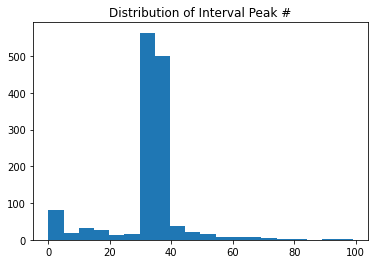

Peak # Median: 34.0
Number of Intervals with a Peak # w/i +-5 of 35: 1076


In [138]:
#exploring the distrbution of observerd peak# in each interval
import statistics as stats
peak_sizes = [len(peaks_list) for peaks_list in peaks_list]
print(peak_sizes)
plt.hist(peak_sizes,20)
plt.title('Distribution of Interval Peak #')
plt.show()
print(f'Peak # Median: {stats.median(peak_sizes)}')
print(f'Number of Intervals with a Peak # w/i +-5 of 35: {len([item for item in peak_sizes if item in range(30,41)])}')

In [249]:
#adjusting peak list and associated rr intervals/hypnogram readings

#adjusting peak list to only include those in designated range
valid_peak_list = [peak for peak in peaks_list if len(peak) in range(30,41)]
valid_peak_interval_indicies = [index for index,peak in enumerate(peaks_list) if len(peak) in range(30,41)]
#adjusting sleep_stages list for binary classification between awake(0) and sleep (1-5)
sleep_stages_list = list(sleep_stages)
adjusted_sleep_stages = [sleep_stages_list[index] for index in valid_peak_interval_indicies]
adjusted_sleep_stages = [int(sleep_stage) for sleep_stage in adjusted_sleep_stages]
valid_sleep_stages = np.array(adjusted_sleep_stages)
valid_sleep_stages[valid_sleep_stages>=1]=1
#adjusting rr interval list
valid_rr_intervals = [np.diff(peak) for peak in valid_peak_list]
print(len(valid_rr_intervals))

[0 0 0 ... 0 0 0]
1076


In [183]:
#cleansing rr intervals data with robust scaler
from sklearn.preprocessing import RobustScaler

"""
transformer = RobustScaler().fit(np.array(valid_rr_intervals[0]).reshape(-1,1))
transformed_arr = transformer.transform(np.array(valid_rr_intervals[0]).reshape(-1,1))
transformed_arr = transformed_arr.T
print(transformed_arr.tolist()[0])
"""
clean_rr_intervals = [0]*len(valid_rr_intervals)

for index,dirty_rr_interval in enumerate(valid_rr_intervals):
  transformer = RobustScaler().fit(np.array(dirty_rr_interval).reshape(-1,1))
  transformed_arr = transformer.transform(np.array(dirty_rr_interval).reshape(-1,1))
  transformed_arr = transformed_arr.T
  clean_rr_intervals[index] = transformed_arr.tolist()[0]
print(clean_rr_intervals[0])

[-0.05555555555555555, 1.1666666666666667, 1.2777777777777777, 0.5, -0.16666666666666666, -0.05555555555555555, 0.5, 0.6111111111111112, 0.5, 0.05555555555555555, 0.16666666666666666, 0.7222222222222222, 0.9444444444444444, 0.6111111111111112, -0.16666666666666666, -0.5, 0.05555555555555555, -0.05555555555555555, -1.0555555555555556, -1.8333333333333333, -1.1666666666666667, -0.6111111111111112, -0.8333333333333334, -1.0555555555555556, -0.6111111111111112, 0.2777777777777778, 0.8333333333333334, 0.3888888888888889, -0.3888888888888889, -0.2777777777777778, 0.16666666666666666, 0.3888888888888889, -0.2777777777777778, -0.7222222222222222, -0.5, 0.16666666666666666]


In [192]:
#padding zeros to end of smaller rr interval arrays
max_rr_interval_num = max([len(rr_interval) for rr_interval in clean_rr_intervals])
for rr_interval in clean_rr_intervals:
  if len(rr_interval)<39:
    add_zero_num = 39-len(rr_interval)
    for _ in range(add_zero_num):
      rr_interval.append(0)
#renaming clearn_rr_intervals --> RR_intervals
RR_intervals = clean_rr_intervals
print(RR_intervals[0])
RR_intervals = np.array(RR_intervals)
print(RR_intervals.shape)

[-0.05555555555555555, 1.1666666666666667, 1.2777777777777777, 0.5, -0.16666666666666666, -0.05555555555555555, 0.5, 0.6111111111111112, 0.5, 0.05555555555555555, 0.16666666666666666, 0.7222222222222222, 0.9444444444444444, 0.6111111111111112, -0.16666666666666666, -0.5, 0.05555555555555555, -0.05555555555555555, -1.0555555555555556, -1.8333333333333333, -1.1666666666666667, -0.6111111111111112, -0.8333333333333334, -1.0555555555555556, -0.6111111111111112, 0.2777777777777778, 0.8333333333333334, 0.3888888888888889, -0.3888888888888889, -0.2777777777777778, 0.16666666666666666, 0.3888888888888889, -0.2777777777777778, -0.7222222222222222, -0.5, 0.16666666666666666, 0, 0, 0]
(1076, 39)
[[-0.05555556  1.16666667  1.27777778 ...  0.          0.
   0.        ]
 [ 0.66666667  0.         -0.4        ...  0.          0.
   0.        ]
 [-0.82352941 -1.41176471 -0.82352941 ...  0.          0.
   0.        ]
 ...
 [-0.203125   -0.48958333  0.20833333 ...  0.          0.
   0.        ]
 [-0.5547

In [ ]:
#pulling function that makes recurrance plots on passed series data
import sklearn as sk

def recurrence_plot(s, eps=None, steps=None):
  if eps==None: eps=0.1
  if steps==None: steps=10
  d = sk.metrics.pairwise.pairwise_distances(s)
  d = np.floor(d / eps)
  d[d > steps] = steps
  #Z = squareform(d)
  return d

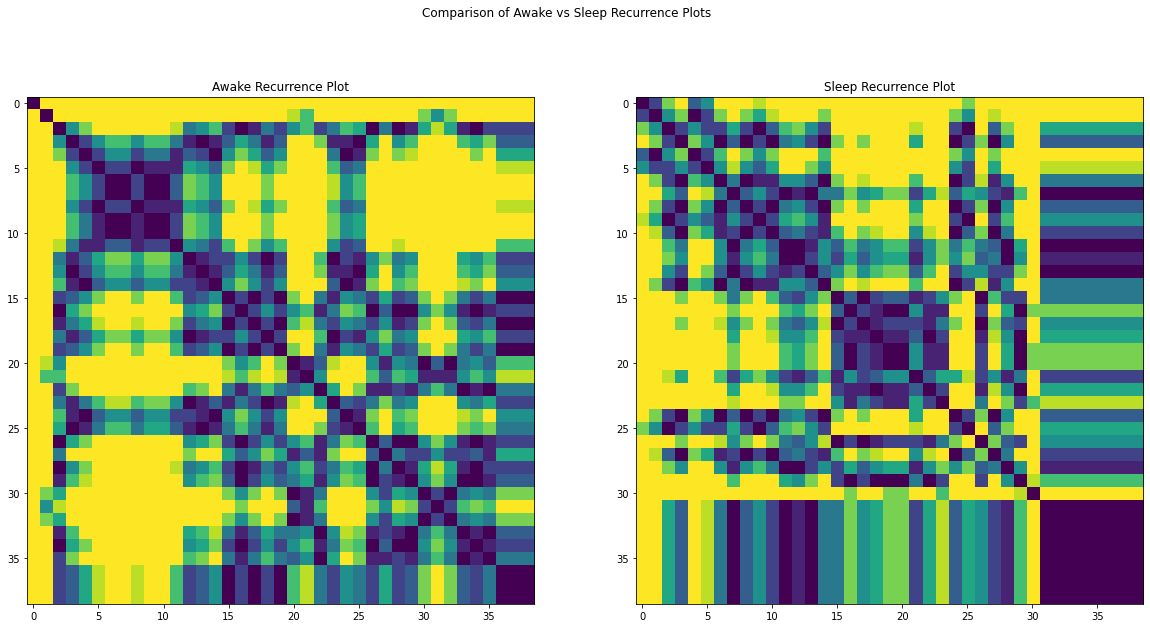

In [291]:
#pulling an awake vs sleep stage index

#making a temp list so we can pull indices where person was awake vs in varying degrees of sleep
valid_sleep_stages_list = list(valid_sleep_stages)
awake_indicies = [index for index,sleep_stage in enumerate(valid_sleep_stages_list) if sleep_stage==0]
sleep_indicies = [index for index,sleep_stage in enumerate(valid_sleep_stages_list) if sleep_stage==1]

#making a recurrance plot of randomly chosen awake vs sleep
rand_wake_index = np.random.choice(awake_indicies)
rand_sleep_index = np.random.choice(sleep_indicies)

awake_rp = recurrence_plot(RR_intervals[rand_wake_index,:].reshape(-1,1))
sleep_rp = recurrence_plot(RR_intervals[rand_sleep_index,:].reshape(-1,1))

fig, axs = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Comparison of Awake vs Sleep Recurrence Plots')
axs[0].imshow(awake_rp)
axs[0].set_title('Awake Recurrence Plot')
axs[1].imshow(sleep_rp)
axs[1].set_title('Sleep Recurrence Plot')
fig.show()

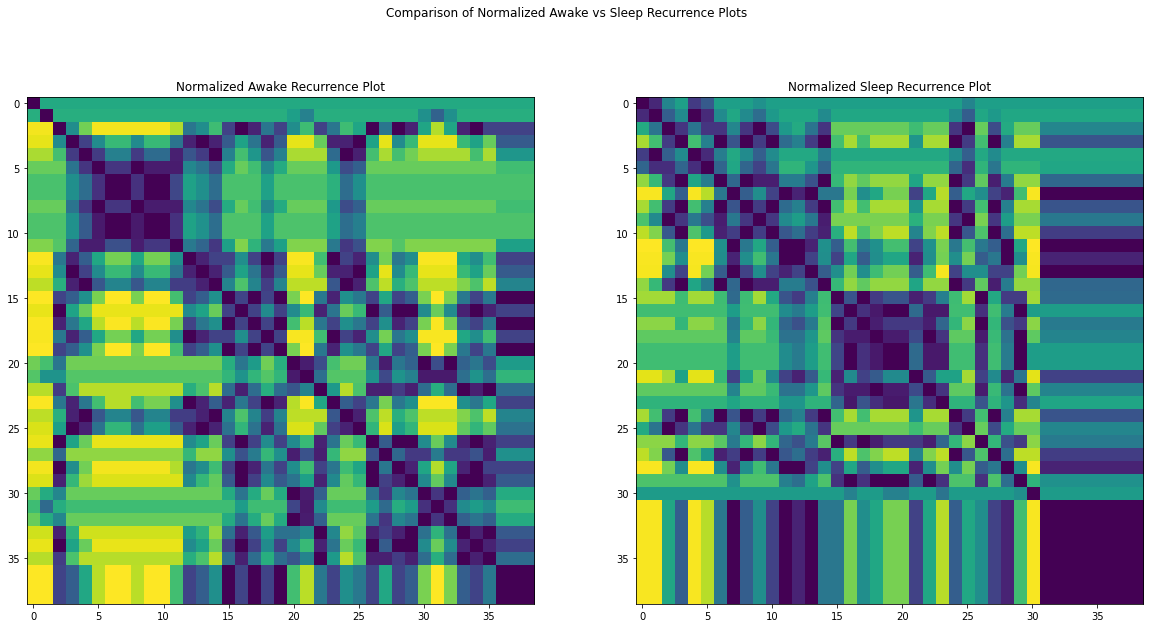

In [292]:
#experimenting to see what normalization does to rp plots
from sklearn.preprocessing import normalize

fig, axs = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Comparison of Normalized Awake vs Sleep Recurrence Plots')
axs[0].imshow(normalize(awake_rp))
axs[0].set_title('Normalized Awake Recurrence Plot')
axs[1].imshow(normalize(sleep_rp))
axs[1].set_title('Normalized Sleep Recurrence Plot')
fig.show()

In [299]:
#note: data input vector is 2d and off size: (39,39)
#note: must normalize each rp plot in the RR_intervals 2d array

#applying the rp function so each interval so we can create our X database
X_data = np.empty((1076,39,39))

for index in range(X_data.shape[0]):
  RR_interval = RR_intervals[index].reshape(-1,1)
  interval_rp = recurrence_plot(RR_interval)
  interval_rp = normalize(interval_rp)
  X_data[index,:,:] = interval_rp
print(X_data.shape)

(1076, 39, 39)


In [293]:
#test-train splitting our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, valid_sleep_stages, test_size=0.15, shuffle=True)

In [297]:
#building CNN to classify between awake vs sleep
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(39, 39, 1)))

TODO:


1.   Build CNN model. Make sure to include regularization techniques so model doesn't overfit
2.   Experiment with different CNN model architecture 
3.   Experiment with fitting CNN model to other 2 sleep datasets
4.  (time permitting) GridSearch to find optimal hyperparaemeters
5.  (time permitting) build feed foward NN to compare accuracies (would be nice to show that CNN is far superior)